Basic e.d.a. on Heartscore data


In [16]:
import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

import os
import sys
from collections import Counter
from collections import namedtuple

In [27]:
os.chdir("T:\laupodteam\AIOS\Bram")
nplots = 3

In [18]:
HS = pd.read_csv("data/HeartScore/Data/MATRIX_FULL_23jul2019_ECG.csv", sep=";")

In [75]:
cols = HS.columns.tolist()

meta_cols = ['setsrc', 'pathos_key', 'upod_id', 'Door', 'Analyzer', 'AcquisitionDateTime_ECG', ]
pheno_cols = ['AGE', 'gender', 'BMI', 'RF_Diab', 'RF_Smok', 'RF_HyperTens', 'RF_HyperChol', 'RF_CVDHist', 'RF_FamHist', 'RF_obese30']
hs_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_new', 'HS_RiskFacts', 'HS_new2']
tn_cols = ['tn_admission', 'tn_slope2', 'HN_TN']

cell_dyn_cols = ["c_b_wbc","c_b_wvf","c_b_neu","c_b_seg","c_b_bnd","c_b_ig","c_b_lym","c_b_lyme","c_b_vlym","c_b_mon","c_b_mone","c_b_blst",
                 "c_b_eos","c_b_bas","c_b_pneu","c_b_pseg","c_b_pbnd","c_b_pig","c_b_plym","c_b_plyme","c_b_pvlym","c_b_pmon","c_b_pmone",
                 "c_b_pblst","c_b_peos","c_b_pbas","c_b_namn","c_b_nacv","c_b_nimn","c_b_nicv","c_b_npmn","c_b_npcv","c_b_ndmn",
                 "c_b_ndcv","c_b_nfmn","c_b_nfcv","c_b_Lamn","c_b_Lacv","c_b_Limn","c_b_Licv","delay_Celldyn"]
ecg_cols_agg =  ["VentricularRate_ECG","AtrialRate_ECG","P_RInterval_ECG","QRS_Duration_ECG","Q_TInterval_ECG",
                 "QTCCalculation_ECG","PAxis_ECG","RAxis_ECG","TAxis_ECG","QRSCount_ECG","QOnset_ECG",
                 "QOffset_ECG","POnset_ECG","POffset_ECG","T_Onset_ECG","T_Offset_ECG","QRS_Onset_ECG",
                 "QRS_Offset_ECG","AvgRRInterval_ECG","QTcFredericia_ECG","QTcFramingham_ECG","QTc_Bazett_ECG"]

ecg_leads = ['Lead_I_', 'Lead_II_', 'Lead_III_', 'Lead_V1_', 'Lead_V2_', 'Lead_V3_', 'Lead_V4_', 'Lead_V5_', 'Lead_V6_', 'Lead_aVF_', 'Lead_aVL_', 'Lead_aVR_']
ecg_msrmnt = ['MaxST_ECG',  'Max_R_Ampl_ECG', 'Max_S_Ampl_ECG', 'MinST_ECG', 'PFull_Area_ECG', 'PP_Area_ECG', 'PP_Duration_ECG',
 'PP_PeakAmpl_ECG', 'PP_PeakTime_ECG', 'P_Area_ECG', 'P_Duration_ECG', 'P_PeakAmpl_ECG', 'P_PeakTime_ECG', 'QRS_Area_ECG', 'QRS_Balance_ECG',
 'QRS_Deflection_ECG', 'QRSint_ECG', 'Q_Area_ECG', 'Q_Duration_ECG', 'Q_PeakAmpl_ECG', 'Q_PeakTime_ECG', 'RP_Area_ECG', 'RP_Duration_ECG', 'RP_PeakAmpl_ECG',
 'RP_PeakTime_ECG', 'R_Area_ECG', 'R_Duration_ECG', 'R_PeakAmpl_ECG', 'R_PeakTime_ECG', 'SP_Area_ECG', 'SP_Duration_ECG', 'SP_PeakAmpl_ECG', 
 'SP_PeakTime_ECG', 'STE_ECG', 'STJ_ECG', 'STM_ECG', 'S_Area_ECG', 'S_Duration_ECG', 'S_PeakAmpl_ECG', 'S_PeakTime_ECG',
 'TFull_Area_ECG', 'TP_Area_ECG', 'TP_Duration_ECG', 'TP_PeakAmpl_ECG', 'TP_PeakTime_ECG', 'T_Area_ECG', 'T_Duration_ECG', 'T_End_ECG',
 'T_PeakAmpl_ECG', 'T_PeakTime_ECG', 'T_Special_ECG']

ecg_cols_dyn = [_lead+_msrmnt for _lead in ecg_leads for _msrmnt in ecg_msrmnt]

var_cols = list(set(cols) - set(meta_cols))

In [20]:
# convert bool in int64
for _col in HS.columns.tolist():
    if str(HS[_col].dtype)=='bool':
        HS[_col] = HS[_col].astype(int)

In [21]:
target = 'casecontrol'
HS.rename(index=str, columns={target: 'target'}, inplace=True)
tmap = {'Control': 0, 'NSTEMI': 1}
HS['target'] = HS.target.map(tmap)

gmap = {'M': 0, 'F': 1}
HS['gender'] = HS.gender.map(gmap)

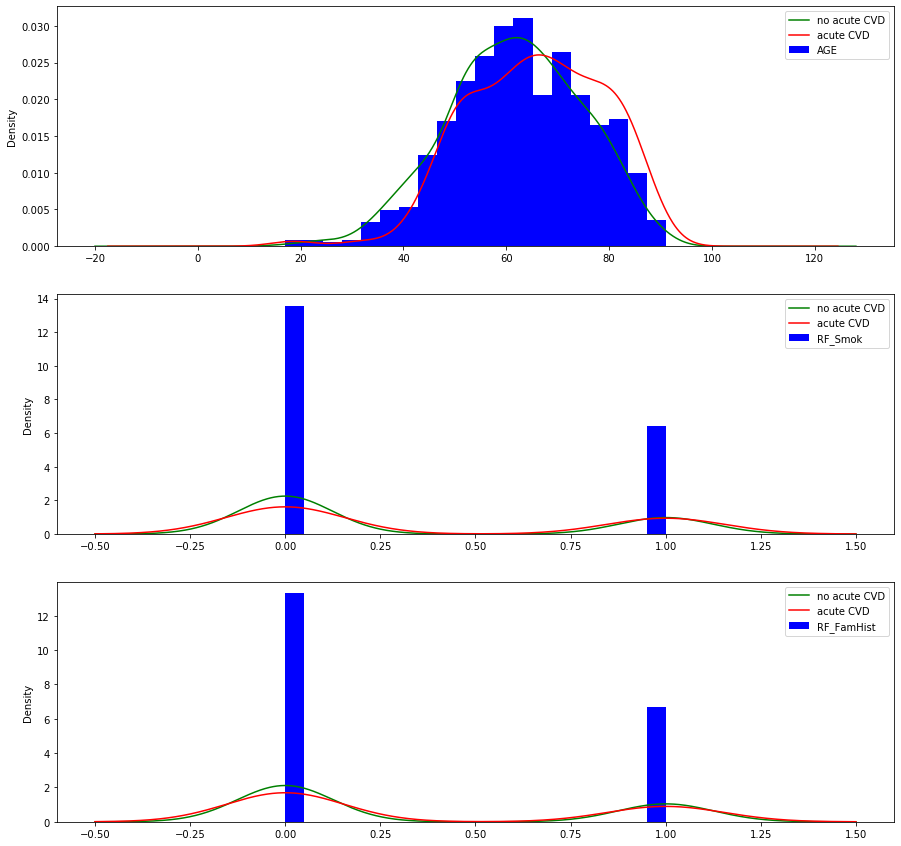

In [85]:
plot_cols = pheno_cols
fig, ax = plt.subplots(figsize=(15, int(50*nplots/10)), nrows=nplots)
for idx, var_col in enumerate(random.choices(plot_cols, k=nplots)):
    HS.loc[:, var_col].plot.hist(bins=20, color='blue', density=True, ax=ax[idx])
    HS.loc[HS.target==0, var_col].plot.kde(color='green', label='no acute CVD', ax=ax[idx])
    HS.loc[HS.target==1, var_col].plot.kde(color='red', label='acute CVD', ax=ax[idx])
    ax[idx].legend()    

In [ ]:
from sklearn.covariance import OAS
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import EmpiricalCovariance

def _cov(x, lib='numpy', method='exact', inverse=False):
    # lib: numpy, scipy, sklearn
    # normalised: True/false  np.corrcoef if true
    # method: exact/shrunk/sparse/empirical
    
    assert method in ['shrunk', 'sparse', 'empirical']
    assert lib in ['numpy', 'scipy', 'sklearn']
    
    if method=='empirical':    
        if (lib=='numpy') | (normalised):
            if normalised:
                cov = np.corrcoef(x)
            else:
                cov = np.cov(x)
            if inverse:
                invcov = np.linalg.inv(cov)
        elif lib=='scipy':
            cov = sc.stats.cov(x)
            if inverse:
                invcov = np.linalg.inv(cov)
        elif lib=='sklearn':
            cm = EmpiricalCovariance().fit(x)
            cov = cm.covariance_
            invconv = cm.precision_
    else:
        if method=='shrunk':
            # return LedoitWolf().fit(x).covariance_
            cm = EmpiricalCovariance().fit(x)
            cov = cm.covariance_
            invcov = cm.precision_
        elif method=='sparse':
            cm = GraphicalLassoCV().fit(x) 
            cov = cm.covariance_
            invcov = cm.precision_
    
    if inverse:
        return cov, invcov
    else:
        return cov, None
    
def _Mahalanobis(v1, v2, inv_cov):
    
    return

def pairwise_similarity(x, cols_left=[], cols_right=[]):
    # assumes PAIRwise similarity measures
    
    # Spearman/Pearson/Kendall/inverse-Mahalanobis(mean/median)/Cosine/Euclidean
    cm = ecg_agg[new_cols].corr()
    np.fill_diagonal(cm.values, 0)
    corr_col_check = (cm>0.9).sum()>0
    
    return sim_scores

In [86]:
# information gain per feature
# delta(1-entropy)

def info_gain(data, target="target", feature_cols=[]):
    # information gain/entropy reduction
    # returns: dictionary of tuples with best split per feature plus the information gain.
    return gain_list

def univariate_sep_score(data, target="target", feature_cols=[]):
    # KS, MWU, KW, (normalised) Wasserstein, FDR
    # returns: dictionary of tuples with seperation scores per feature
    
    return sep_list

def multivariate_sep_score(data, target="target", feature_cols=[]):
        
    
    return sep_list

def dim_reduce(data, reducer, **kwargs):
    return red_data  


def pipe(data, actions=[]):
    '''
        actions=[{'reduce':{'dims': 10, 'type': 'PCA'}, 
                  'sep_score':{'features':[]}, 
                  'info_gain':{'features':[]},
                  'classifier': {'models':['CART']},
                  }]
    ''' 

SyntaxError: invalid syntax (<ipython-input-86-2fb752cab1aa>, line 15)

In [ ]:
# information gain per feature pair
# polynomial expansion
from sklearn.preprocessing import PolynomialFeatures as PF

Expander = PF(degree=2, interaction_only=False, include_bias=False)
ExpDF = pd.DataFrame(Expander.fit_transform(HS.fillna(0).loc[:, var_cols]))
FeatureNames = Expander.get_feature_names(HS.loc[:, var_cols].columns)
ExpDF.columns = FeatureNames
ExpDF.loc[:, 'target'] = HS['target'].values

# seperation score (KS/Wasserstein/MWU)

# supervised dim reduce plus density-based clustering

# Logistic Regression with polynomial expansion
# Add features in order of feature pair

# biGAM's

# RF with permutation importance